In [34]:
# importing a bunch of stuff we need
import os
import re
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import sklearn
from sklearn.metrics import accuracy_score
import scipy
import pandas as pd
import requests
import pathlib
from bert_score import score as bertscore

print("imports successful")

imports successful


In [35]:
# Try to infer the current notebook/script name (safe default if not running interactively)
notebook_name = pathlib.Path(__file__).stem if '__file__' in globals() else "notebook_session"

# Define directory for checkpoints
checkpoint_dir = os.path.join("checkpoints", notebook_name)
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"checkpoints saved to: {checkpoint_dir}")


checkpoints saved to: checkpoints/notebook_session


In [36]:
#setting up scorer for our sentences
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_model.eval()

def score_with_gpt2(sentence): #uses log likelihood to assess sentence accuracy. Lower => more fluent
    inputs = gpt2_tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = gpt2_model(**inputs, labels=inputs["input_ids"])
    return outputs.loss.item()
print("complete")

# load the 6-word "sentences"
with open("sensical_sentences_6words.txt", "r") as f:
    lines = [line.strip() for line in f if len(line.strip().split()) == 6]

# prepare structured data (structured with data & score)
scored_data = []
for sentence in lines:
    words = sentence.split()
    input_words = words[:5]
    target_word = words[5]
    full_sentence = " ".join(words)
    score = score_with_gpt2(full_sentence)

    scored_data.append({
        "input": " ".join(input_words),
        "target": target_word,
        "score": score
    })


print("Scored", len(scored_data), "sentences.")

complete
Scored 100 sentences.


In [37]:
#grabbing sample text to train off of
url = "https://www.gutenberg.org/files/11/11-0.txt"  # this just links to a copy of "Alice in Wonderland", which we're using here since it's in the public domain :)
#AiWl is fairly large being ~27,500 words
response = requests.get(url)
raw_text = response.text


#function to tokenize AiWl
def ttokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = text.split()
    return words

words = ttokenize(raw_text)


In [38]:
vocab_limit = 5000 #forcing the model to only use the most common 5000 words to maintain simplicty
word_counts = Counter(words)
most_common = word_counts.most_common(vocab_limit - 1)
vocab = [w for w, _ in most_common]
vocab.append("<UNK>")

word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

def encode(words): #encoding words into a numerical representation
    return [word2idx.get(w, word2idx["<UNK>"]) for w in words]

def decode(indices): #deoding numbers back to their word counterparts
    return ' '.join(idx2word[i] for i in indices)

encoded = encode(words) #encoding words into a numerical representation


In [39]:
class MyDataset(Dataset): #making a helper dataset class
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx : idx + self.seq_len])
        y = torch.tensor(self.data[idx + self.seq_len])
        return x, y

seq_len = 5
dataset = MyDataset(encoded, seq_len) #shoving our data as encoded previously into MyDataset
loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

In [40]:
class myLM(nn.Module): # actually defining the model here
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1])  # only use the last time step
        return out

vocab_size = len(vocab)
model = myLM(vocab_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [41]:
num_epochs = 5
for epoch in range(num_epochs): # training with 5 epochs, can change this to be more or lesschange the effectiveness of the model
    total_loss = 0
    for inputs, targets in loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"epoch {epoch+1}, Loss: {total_loss:.4f}")
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"neural_lm_epoch{epoch+1}.pt"))

epoch 1, Loss: 2386.9151
epoch 2, Loss: 1900.3770
epoch 3, Loss: 1500.3605
epoch 4, Loss: 1145.7173
epoch 5, Loss: 882.7313


In [42]:
# tokenizer for the GRU model
class Tokenizer:
    def __init__(self, text):
        self.words = text.lower().split()
        vocab = sorted(set(self.words))
        if "<UNK>" not in vocab:
            vocab.append("<UNK>")
        self.vocab = vocab
        self.word2idx = {w: i for i, w in enumerate(self.vocab)}
        self.idx2word = {i: w for w, i in self.word2idx.items()}

    def encode(self, text): #similar to earlier, converting words to a numerical format
        return [self.word2idx.get(w, self.word2idx["<UNK>"]) for w in text.lower().split()]

    def decode(self, indices): #similar to earlier, converting numbers back to words
        return ' '.join(self.idx2word.get(i, "<UNK>") for i in indices)

tokenizer = Tokenizer(" ".join(words))


In [43]:
def predict_next_word(seed_text): #predicts the next word
    model.eval() #sets the model to evaluation mode
    seed_words = ttokenize(seed_text)[-seq_len:] #tokenizing the given phrase we have to expand
    encoded_input = encode(seed_words) #encoding the given phrase we have to expand
    if len(encoded_input) < seq_len: #expanding the given phrase if it is not long enough
        encoded_input = [0] * (seq_len - len(encoded_input)) + encoded_input
    input_tensor = torch.tensor([encoded_input])
    with torch.no_grad():
        output = model(input_tensor) #using the pytorch model to guess the answer
        next_word_id = torch.argmax(output, dim=-1).item()
    return idx2word[next_word_id]

results = [] # just going to store our results here

for entry in scored_data:
    input_text = entry["input"]
    true_target = entry["target"]

    # encode the input using tokenizer
    token_ids = tokenizer.encode(input_text) 
    if len(token_ids) < seq_len:
        token_ids = [0] * (seq_len - len(token_ids)) + token_ids
    input_tensor = torch.tensor([token_ids])

    # predict next word using the GRU model
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        next_word_id = torch.argmax(output, dim=-1).item()
        predicted_word = tokenizer.idx2word.get(next_word_id, "<UNK>")

    # expand sentence and score it with GPT-2
    full_sentence = input_text + " " + predicted_word
    score = score_with_gpt2(full_sentence)

    results.append({
        "input": input_text,
        "true_target": true_target,
        "predicted": predicted_word,
        "score": score
    })

print("finished evaluating", len(results), "examples.")


finished evaluating 100 examples.


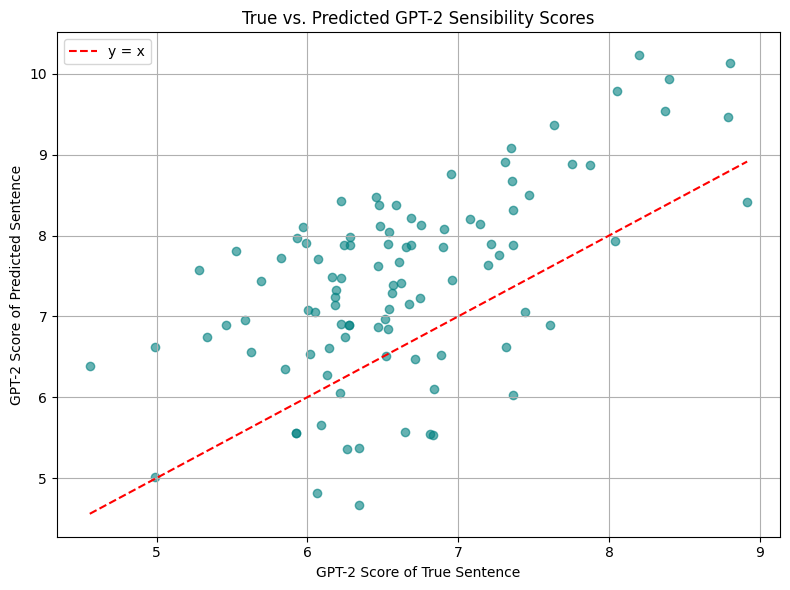

In [44]:
#pretty much done now just gonna plot everything

true_scores = [entry["score"] for entry in scored_data]
predicted_scores = [entry["score"] for entry in results]

plt.figure(figsize=(8, 6))
plt.scatter(true_scores, predicted_scores, alpha=0.6, color='teal')
plt.plot([min(true_scores), max(true_scores)], [min(true_scores), max(true_scores)], 'r--', label='y = x')

plt.xlabel("GPT-2 Score of True Sentence")
plt.ylabel("GPT-2 Score of Predicted Sentence")
plt.title("True vs. Predicted GPT-2 Sensibility Scores")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
# displaying some of the results (sanity check)
for i, (truth, pred) in enumerate(zip(scored_data, results)):
    print(f"Example {i+1}")
    print(f"Input:           {truth['input']}")
    print(f"True target:     {truth['target']}")
    print(f"Predicted word:  {pred['predicted']}")

    full_true = f"{truth['input']} {truth['target']}"
    full_pred = f"{truth['input']} {pred['predicted']}"

    print(f"true sentence:      {full_true}")
    print(f"predicted sentence: {full_pred}")
    print(f"Score (true):    {truth['score']:.3f}")
    print(f"Score (pred):    {pred['score']:.3f}")
    print("-" * 60)

    if i == 9:
        break  # Only show first 10 for now


Example 1
Input:           Alice talked to the garden
True target:     carefully
Predicted word:  againbefore
true sentence:      Alice talked to the garden carefully
predicted sentence: Alice talked to the garden againbefore
Score (true):    6.897
Score (pred):    7.861
------------------------------------------------------------
Example 2
Input:           She opened a door by
True target:     mistake
Predicted word:  anxious
true sentence:      She opened a door by mistake
predicted sentence: She opened a door by anxious
Score (true):    5.459
Score (pred):    6.895
------------------------------------------------------------
Example 3
Input:           It sat on the queen
True target:     gracefully
Predicted word:  above
true sentence:      It sat on the queen gracefully
predicted sentence: It sat on the queen above
Score (true):    6.273
Score (pred):    6.898
------------------------------------------------------------
Example 4
Input:           The dog found a mirror
True target:

In [46]:
#running it with bertscore here, nothing too interesting
bertscored_data = []

for line in lines:
    words = line.strip().split()
    input_words = words[:5]
    target_word = words[5]
    full_sentence = " ".join(words)

    _, _, F1 = bertscore([full_sentence], [full_sentence], lang="en", verbose=False)

    bertscored_data.append({
        "input": " ".join(input_words),
        "target": target_word,
        "bertscore": F1.item()
    })

print(f"scored {len(bertscored_data)} true sentences with BERTScore.")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

scored 100 true sentences with BERTScore.


In [47]:
bertscore_results = []

for i, entry in enumerate(bertscored_data):
    input_text = entry["input"]
    true_target = entry["target"]

    token_ids = tokenizer.encode(input_text) #predicting with GRU model
    if len(token_ids) < seq_len:
        token_ids = [0] * (seq_len - len(token_ids)) + token_ids
    input_tensor = torch.tensor([token_ids])

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        next_token_id = torch.argmax(output, dim=-1).item()
        predicted_word = tokenizer.idx2word.get(next_token_id, "<UNK>")

    # Compose full predicted sentence
    predicted_sentence = input_text + " " + predicted_word
    reference_sentence = input_text + " " + true_target

    _, _, F1 = bertscore([predicted_sentence], [reference_sentence], lang="en", verbose=False)

    bertscore_results.append({
        "input": input_text,
        "true_target": true_target,
        "predicted": predicted_word,
        "bertscore": F1.item()
    })

print(f"scored {len(bertscore_results)} predicted sentences with BERTScore.")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

scored 100 predicted sentences with BERTScore.


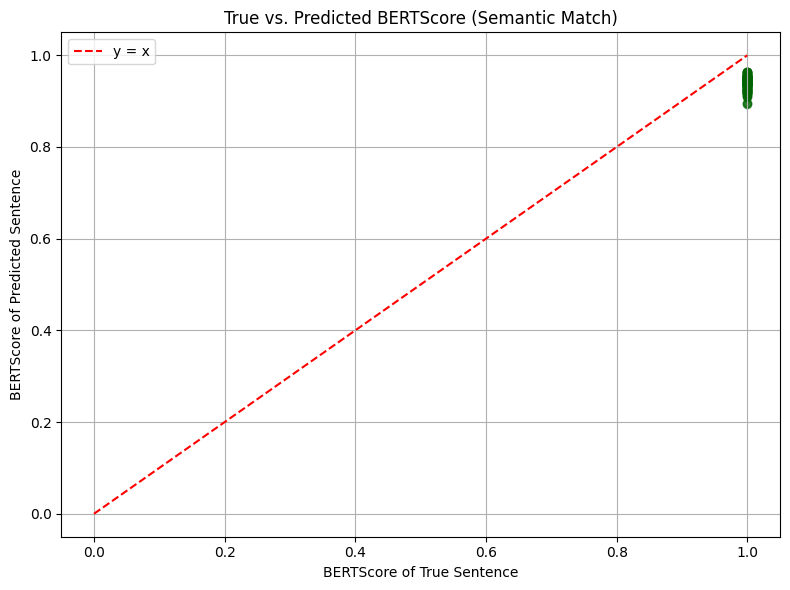

In [48]:
#plotting, nothing too interesting
true_scores = [entry["bertscore"] for entry in bertscored_data]
predicted_scores = [entry["bertscore"] for entry in bertscore_results]

plt.figure(figsize=(8, 6))
plt.scatter(true_scores, predicted_scores, alpha=0.6, color='darkgreen')
plt.plot([0, 1], [0, 1], 'r--', label='y = x')
plt.xlabel("BERTScore of True Sentence")
plt.ylabel("BERTScore of Predicted Sentence")
plt.title("True vs. Predicted BERTScore (Semantic Match)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
# displaying first 10 results (sanity check)
for i, (true, pred) in enumerate(zip(bertscored_data, bertscore_results)):
    true_sentence = f"{true['input']} {true['target']}"
    predicted_sentence = f"{pred['input']} {pred['predicted']}"

    print(f"Example {i+1}")
    print(f"Input:            {true['input']}")
    print(f"True Target:      {true['target']}")
    print(f"Predicted Word:   {pred['predicted']}")
    print(f"True Sentence:      {true_sentence}")
    print(f"Predicted Sentence: {predicted_sentence}")
    print(f"BERTScore (True):      {true['bertscore']:.4f}")
    print(f"BERTScore (Predicted): {pred['bertscore']:.4f}")
    print("-" * 70)
    
    if i == 9:
        break  # only show first 10


Example 1
Input:            Alice talked to the garden
True Target:      carefully
Predicted Word:   againbefore
True Sentence:      Alice talked to the garden carefully
Predicted Sentence: Alice talked to the garden againbefore
BERTScore (True):      1.0000
BERTScore (Predicted): 0.9377
----------------------------------------------------------------------
Example 2
Input:            She opened a door by
True Target:      mistake
Predicted Word:   anxious
True Sentence:      She opened a door by mistake
Predicted Sentence: She opened a door by anxious
BERTScore (True):      1.0000
BERTScore (Predicted): 0.9185
----------------------------------------------------------------------
Example 3
Input:            It sat on the queen
True Target:      gracefully
Predicted Word:   above
True Sentence:      It sat on the queen gracefully
Predicted Sentence: It sat on the queen above
BERTScore (True):      1.0000
BERTScore (Predicted): 0.9342
----------------------------------------------------